# Data Analysis

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
import os
import cv2
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from typing import Union

## Import Data

In [2]:
f = open("./dataset/train.csv", "r")
data = f.readlines()
f.close()

## Performing Text Cleaning & Data Extraction (Possibly for NLP)

We will see how to code and clean the textual data for the following methods.
- Lowecasing the data
- Removing Puncuatations
- Removing Numbers
- Removing extra space
- Replacing the repetitions of punctations
- Removing Emojis
- Removing emoticons
- Removing Contractions
Reference: https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/

Manual Data Cleaning:
- Remove `\n` character that breaks the caption into two lines (1014.jpg)
- Remove `\n` character that breaks the caption into two lines (2259.jpg)
- Remove `\n` character that breaks the caption into two lines (6751.jpg)
- Remove **a couple of** `\n` character that breaks the caption into two lines (24624.jpg)

**Note: there is no label 12! [Label starts from 1 to 19]**

### Class Labels

There are 19 classes: class starts from 1 to 19. There is no label 12 assigned to any image. <br>
For one-hot encoding: the 0-the index will represent class 1.

In [3]:
# for removing punctuations
translator = str.maketrans("", "", string.punctuation)

#TODO: some captions contain "ski's, someone's": how to make use of this?

# store the data into different lists
image_ids = []
captions = []

# changing the label to one-hot encoding
n_instances = len(data) - 1 # excl. first line
n_classes = 19
labels = np.zeros((n_instances, n_classes))

# iterate each line
for i, line in enumerate(data):

	# ignore the first line
	if (i == 0): continue

	# step 1: get only the caption data
	# reference: https://stackoverflow.com/questions/15043326/getting-string-between-2-characters-in-python
	caption = line[line.find('\"')+1:-1]

	# step 2: lowercase the data
	caption = caption.lower()

	# step 3: removing punctuations
	# reference: https://blog.enterprisedna.co/python-remove-punctuation-from-string/
	caption = caption.translate(translator)

	# step 4: removing numbers
	# reference: https://stackoverflow.com/questions/817122/delete-digits-in-python-regex
	caption = re.sub('\d+', '', caption)

	# step 5: removing extra space
	caption = " ".join(caption.split())

	# split them to three different data: image id, label and caption
	line = line.split(",")
	image_id = line[0]
	label = line[1]

	# step 6: store them to lists
	image_ids.append(image_id)
	captions.append(caption)
	
	# step 7: create a one-hot encoded label
	multi_labels = label.split(" ")
	for label in multi_labels:
		labels[i - 1][int(label) - 1] = 1


## Changing the Lists to DataFrame type

In [47]:
# create pandas dataframe object
data = {'image_id': image_ids, 'caption': captions}
for label in range(19):
	data[f'class {label + 1}'] = labels.T[label]
df = pd.DataFrame(data)

# number of instances
print(f"Number of instances: {df.shape[0]}")

Number of instances: 30000


### Remove instances with only class 1 (Data Imbalance Problem)

In [48]:
def remove_class(df: pd.DataFrame, class_no: int) -> pd.DataFrame:
    """
    Since there is a data imbalance, we can remove instances with a large number of only a single class.
    """
    # get the instances with ONLY class no given
    df_n = df[df[f'class {class_no}'] == 1.0]
    for n in range(2, 19 + 1):
        df_n = df_n[df_n[f'class {n}'] == 0.0]

    # remove instances with ONLY class no given
    df_no_n = pd.concat([df, df_n]).drop_duplicates(keep=False)

    return df_no_n

df_no_1 = remove_class(df, class_no=1)
df_no_1_and_3 = remove_class(df_no_1, class_no=3)

print(f"Number of instances: {df_no_1_and_3.shape[0]}")

Number of instances: 15925


### Get the Frequency of Labels

Reference: https://www.kaggle.com/code/gustavo9898/mlic-resnet

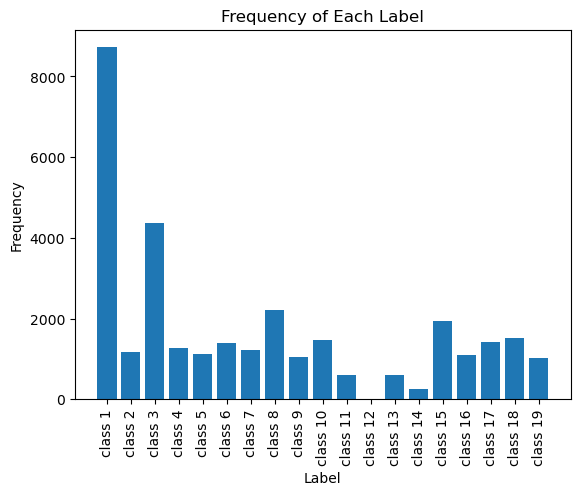

In [46]:
counts = {}
data = df_no_1_and_3

# loop through the label range
for i in range(2, 21):
	col = data.iloc[:, i]
	counts[f"class {i - 1}"] = col.sum()

plt.bar(counts.keys(), counts.values())
plt.title("Frequency of Each Label")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


## Create the Dataset

In [19]:
class MultiLabelDataset(Dataset):
    
	def __init__(self, csv_file: Union[str, pd.DataFrame], root_dir: str, transform=None) -> None:
		"""
		Arguments:
			csv_file (string): path to the csv file with annotations or pandas' dataframe.
			root_dif (string): directory with all the images.
			transform (callable, optional): Optional transform to be applied on a sample.
		"""
		self.df = csv_file
		if (type(csv_file) != pd.DataFrame):
			self.df = pd.read_csv(csv_file)
		self.root_dir = root_dir
		self.transform = transform

	def __len__(self) -> int:
		return len(self.df)
	
	def __getitem__(self, idx):
		
		if (torch.is_tensor(idx)):
			idx = idx.tolist()
		
		# load the image
		img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
		image = cv2.imread(img_name, flags=1)

		# get the labels
		labels = torch.Tensor(self.df.iloc[idx, 2:])

		# apply any transformations
		if (self.transform):
			image = self.transform(image)

		return image, labels

## Initialise some Transformations

!TODO: need normalization, random flipping, random rotation, etc.

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

## Load the Dataset and Split Dataset into Batches

In [20]:
dataset = MultiLabelDataset(
    csv_file=df,
    root_dir='./dataset/data/',
    transform=transform,
)

batch_size = 16
train_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

b_imgs, b_labels = next(iter(train_loader))
print('A batch of imgs shape:', b_imgs.shape)
print('A batch of labels shape:', b_labels.shape)

A batch of imgs shape: torch.Size([16, 3, 256, 256])
A batch of labels shape: torch.Size([16, 19])


/tmp/ipykernel_35552/441980821.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])


## Define Model, Optimizer, Loss Function, etc.

In [10]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

n_features = model.fc.in_features
n_out = 19
model.fc = nn.Linear(n_features, n_out)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


## Perform Training

In [12]:
threshold = 0.2 # the minimum probability of assigning one class

n_epochs = 10
train_losses = []
train_accs = []
for epoch in range(n_epochs):

    n_total = 0
    n_correct = 0
    train_loss = 0.
    model.train()
    for (images, labels) in train_loader:

        if torch.cuda.is_available():
            images = images.to('cuda')
            labels = labels.to('cuda')

        # set gradient to zero
        optimizer.zero_grad()
        
        # forward
        outputs = model(images)

        # backward
        loss = loss_fn(outputs, labels)
        loss.backward()

        # update
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.sigmoid(outputs).data > threshold
        n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
        n_total += len(train_loader)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(n_correct / n_total)

    print("Epoch {:d}, Train Loss: {:.5f}, Train Accuracy: {:.3f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))


/tmp/ipykernel_35552/3676266987.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:21])


Epoch 1, Train Loss: 0.16346885525782903, Train Accuracy: 0.0032551821786910295


KeyboardInterrupt: 

## 

## Multi-Label Image Classification

Tutorials:
- [Build First Multi-Label Image Classification Model Python](https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/)